In [1]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
from IPython.display import HTML
from utils import *
from d_star.d_star import DStar
import multiprocessing
from tqdm import tqdm

np.random.seed(0)
%matplotlib inline

Pedestrians' average speed: 35 by x-coordinate and 30 by y-coordinate.

So let's assume pedestrian takes the whole 30x30 block. That minimize our 1920x1080 field to 64x36 on which we will be calculate robot's path

In [2]:
STEP = 30

In [3]:
paths = np.load('src/all_not_ext_paths_with_ids.npy')
ped_time = (paths[:, 1] / 20).astype(int)
ped_col = (paths[:, 2] / STEP).astype(int)
ped_row = (paths[:, 3] / STEP).astype(int)

In [4]:
obs = Image.open('src/Images/obstacles.png')
obs = (~np.array(obs).sum(axis=2).astype(bool)).astype(int)

grid = np.zeros((int(FRAME_HEIGHT / STEP), int(FRAME_WIDTH / STEP)), dtype=int)

for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        x1, x2 = i * STEP, (i + 1) * STEP
        y1, y2 = j * STEP, (j + 1) * STEP
        if obs[x1 : x2, y1 : y2].sum() > STEP * STEP / 2:
            grid[i, j] = 1

In [5]:
def check_path(start_time, row_start, col_start, row_goal, col_goal):
    assert 0 <= row_start < FRAME_HEIGHT / STEP
    assert 0 <= col_start < FRAME_WIDTH / STEP
    assert 0 <= row_goal < FRAME_HEIGHT / STEP
    assert 0 <= col_goal < FRAME_WIDTH / STEP
    assert 0 <= start_time <= 6000
    
    assert grid[row_start, col_start] == 0
    assert grid[row_goal, col_goal] == 0

    t = ped_time == start_time
    ped_row_time = ped_row[t]
    ped_col_time = ped_col[t]
    ind = (ped_row_time == row_start) * (ped_col_time == row_goal)
    assert not ind.any()

In [6]:
class Robot:
    def __init__(self, grid, ped_time, ped_col, ped_row, score=1):
        self.grid = grid
        self.ped_time = ped_time
        self.ped_col = ped_col
        self.ped_row = ped_row
#         self.trace = []
        self.collisions = 0
        self.set_score(score)
        self.obstacles = []
        
    def get_grid(self, time, row, col):
        t = self.ped_time == time
        ped_row_time = self.ped_row[t]
        ped_col_time = self.ped_col[t]

        im = Image.open(get_framename(time * 20))

        draw = ImageDraw.Draw(im)
        for i in range(int(FRAME_HEIGHT / STEP)):
            for j in range(int(FRAME_WIDTH / STEP)):
                if self.grid[i,j] == 1:
                    continue
                ind = (ped_row_time == i) * (ped_col_time == j)
                if ind.any():
                    row1, row2 = i * STEP, (i + 1) * STEP
                    col1, col2 = j * STEP, (j + 1) * STEP
                    draw.rectangle((col1+1, row1+1, col2, row2), fill='blue')

        row1, row2 = row * STEP, (row + 1) * STEP
        col1, col2 = col * STEP, (col + 1) * STEP
        draw.rectangle((col1+1, row1+1, col2, row2), fill='red')

        return im
    
    def neighbor_cells(self, i, j, r):
        res = [(x, j-r) for x in range(i-r, i+r+1)]
        res += [(x, j+r) for x in range(i-r, i+r+1)]
        res += [(i-r, y) for y in range(j-r+1, j+r)]
        res += [(i+r, y) for y in range(j-r+1, j+r)]
        return res
    
    def check_cell(self, time, row, col):
        t = self.ped_time == time
        ped_row_time = self.ped_row[t]
        ped_col_time = self.ped_col[t]
        ind = (ped_row_time == row) * (ped_col_time == col)
        return ind.any()

    def plan_path(self, start_time, row_start, col_start, row_goal, col_goal):
        self.pf = DStar(row_start, col_start, row_goal, col_goal)

        for i, row in enumerate(self.grid):
            for j, cell in enumerate(row):
                if cell == 1:
                    self.pf.update_cell(i, j, -1)

        self.update_obstacles(start_time, row_start, col_start)
        for i, j in self.obstacles:
                self.pf.update_cell(int(i), int(j), -1)

        self.pf.replan()
        
    def get_path(self, start_time, row_start, col_start, row_goal, col_goal):
#         self.trace = []
        self.collisions = 0
        self.obstacles = []
        
        self.plan_path(start_time, row_start, col_start, row_goal, col_goal)

        time = start_time
        row_cur, col_cur = row_start, col_start

        while row_cur != row_goal or col_cur != col_goal:
#             self.trace.append(self.get_grid(time, row_cur, col_cur))
            
            if self.check_cell(time, row_cur, col_cur):
                self.collisions += 1
            
            for i, j in self.obstacles:
                self.pf.update_cell(int(i), int(j), 0)
            self.obstacles = []

            self.pf.update_start(row_cur, col_cur)
            self.update_obstacles(time, row_cur, col_cur)
            for i, j in self.obstacles:
                self.pf.update_cell(int(i), int(j), -1)
    
            if not self.pf.replan():
                self.plan_path(time, row_cur, col_cur, row_goal, col_goal)
                
            if len(self.pf.get_path()) > 0:
                row_cur, col_cur = self.pf.get_path()[1].x, self.pf.get_path()[1].y
                
            time += 1
            
        return time - start_time
            
#         self.trace.append(self.get_grid(time, row_cur, col_cur))

In [7]:
class DummyRobot(Robot):
    
    def set_score(self, score):
        self.score = 1
    
    def update_obstacles(self, time, row, col):
        self.obstacles = []
        t = self.ped_time == time
        ped_row_time = self.ped_row[t]
        ped_col_time = self.ped_col[t]

        for i, j in self.neighbor_cells(row, col, 1):
            ind = (ped_row_time == i) * (ped_col_time == j)
            if ind.any():
                self.obstacles.append((i, j))
                for x, y in self.neighbor_cells(i, j, 1):
                    self.obstacles.append((x, y))
        
        possible_pedestrians = self.neighbor_cells(row, col, 2)
        bad_cells = []
        for i, j in possible_pedestrians:
            ind = (ped_row_time == i) * (ped_col_time == j)
            if ind.any():
                bad_cells += self.neighbor_cells(i, j, 1)
        
        for i, j in self.neighbor_cells(row, col, 1):
            if (i, j) in bad_cells:
                self.obstacles.append((i, j))

In [8]:
class BullyRobot(Robot):
    
    def set_score(self, score):
        self.score = score

    def update_obstacles(self, time, row, col):
        self.obstacles = []
        for r in range(2):
            t = self.ped_time == time + r
            ped_row_time = self.ped_row[t]
            ped_col_time = self.ped_col[t]

            for i, j in self.neighbor_cells(row, col, 1):
                if r == 1 and np.random.rand() > self.score:
                    continue
                ind = (ped_row_time == i) * (ped_col_time == j)
                if ind.any():
                    self.obstacles.append((i, j))

In [9]:
class CuddlyRobot(BullyRobot):
    
    def set_score(self, score):
        self.score = 1

In [10]:
%%capture

def get_animation(trace):
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)  # removes white border
    imgs = [(ax.imshow(img), ax.annotate('',(5,5))) for img in trace] 

    return animation.ArtistAnimation(fig, imgs, interval=200, repeat_delay=2000, blit=False)

In [11]:
gen_paths = np.load('src/gen_paths.npy')

In [12]:
dummy = DummyRobot(grid, ped_time, ped_col, ped_row)
cuddly = CuddlyRobot(grid, ped_time, ped_col, ped_row)
bully = BullyRobot(grid, ped_time, ped_col, ped_row, score=0.8)

In [13]:
robot = bully

In [14]:
path_time = []
collisions = []

for start_time, row_start, col_start, row_goal, col_goal, opt_time in tqdm(gen_paths):
    path_time.append(robot.get_path(int(start_time), int(row_start), int(col_start), int(row_goal), int(col_goal)))
    collisions.append(robot.collisions)

100%|██████████| 975/975 [01:07<00:00, 14.45it/s]


In [16]:
results = np.load('src/results.npy')

In [17]:
# cuddly, dummy, bully 0.2-0.4-0.8 
results = np.append(results, [path_time, collisions], axis=0)

In [19]:
results.sum(axis=1)

array([14850,    22, 15749,   144, 14835,   191, 14839,   156, 14848,    57])

In [21]:
np.save('src/results', results)

In [36]:
N = 6
ind = np.arange(N) + 0.2
width = 0.35
total_time = np.concatenate(([gen_paths[:,-1].sum()], results.sum(axis=1)[::2]))
total_collisions = np.concatenate(([0], results.sum(axis=1)[1::2]))

In [48]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

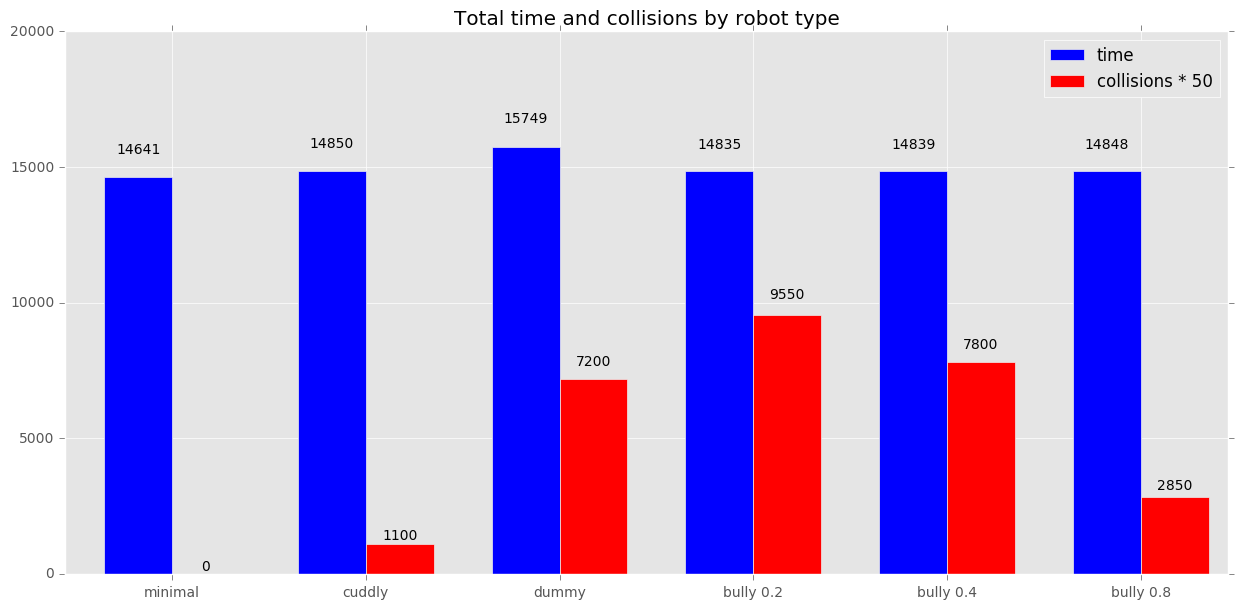

In [52]:
fig, ax = plt.subplots()
rects1 = ax.bar(ind, total_time, width, color='b')
rects2 = ax.bar(ind + width, total_collisions * 50, width, color='r')

ax.set_title('Total time and collisions by robot type')
ax.set_xticks(ind + width)
ax.set_xticklabels(('minimal', 'cuddly', 'dummy', 'bully 0.2', 'bully 0.4', 'bully 0.8'))
ax.legend((rects1[0], rects2[0]), ('time', 'collisions * 50'))
ax.set_ylim(top=20000)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height), ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [ ]:
%%capture
anim = get_animation(robot.trace)

In [ ]:
rc('animation', html='html5')
anim

In [ ]:
anim.save('src/Images/anim.gif', writer='imagemagick', fps=5)